In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import os

In [15]:
file_feather_path = 'output_dataset_with_mfcc_uri.feather'
dataset = pd.read_feather(file_feather_path)

# -----------------------------
# 1. playlist_genre
# -----------------------------
encoder = LabelEncoder()
dataset['genre_int'] = encoder.fit_transform(dataset['playlist_genre'])

num_classes_genres = len(encoder.classes_)
genres_onehot = to_categorical(dataset['genre_int'], num_classes_genres)

onehot_df_genres = pd.DataFrame(
    genres_onehot,
    columns=[f"genre_{cls}" for cls in encoder.classes_]
)


dataset = pd.concat([dataset, onehot_df_genres], axis=1)

useless_to_learn_columns = ['amp_path', 'playlist_genre','track_artist', 'track_album_name', 'track_name', 'track_album_release_date', 'id', 'playlist_subgenre', 'type', 'playlist_id', 'sampling_rate', 'genre_int', 'track_popularity']

regs_columns = ["energy", "tempo", "danceability", "loudness", "liveness","valence", "time_signature", "speechiness", "instrumentalness", "mode", "key", "acousticness"]

dataset_for_learning = dataset.drop(columns=useless_to_learn_columns)

print(dataset.shape)


(1415, 54)


In [16]:
def build_crnn(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # --- CNN ---
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    # --- prepare for LSTM ---
    shape = tf.keras.backend.int_shape(x)
    _, h, w, c = shape
    x = layers.Reshape((w, h * c))(x)

    # --- LSTM ---
    x = layers.LSTM(128, return_sequences=False)(x)

    # --- represenatation ---
    base = layers.Dense(128, activation='relu')(x)

    # --- clasification output ---
    class_out = layers.Dense(num_classes, activation='softmax', name="class_output")(base)

    # --- regression output ---
    reg_out = layers.Dense(1, activation='linear', name="reg_output")(base)

    model = models.Model(inputs, [class_out, reg_out])

    model.compile(
        optimizer='adam',
        loss={
            "class_output": "categorical_crossentropy",
            "reg_output": "mse"
        },
        metrics={
            "class_output": "accuracy",
            "reg_output": "mae"
        }
    )

    return model


In [17]:
input_shape = (40, 2583, 3)
num_classes = len(dataset_for_learning.columns) - len(regs_columns) - 1
print(num_classes)

crnn_model = build_crnn(input_shape, num_classes)
crnn_model.summary()

28
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40, 2583, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 40, 2583, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 40, 2583, 32  128        ['conv2d_2[0][0]']               
 rmalization)                   )                                                        

In [18]:
class AudioGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size, num_classes, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.df) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx*self.batch_size : (idx+1)*self.batch_size]

        X_batch = []
        y_class_batch = []
        y_reg_batch = []


        for _, row in batch_df.iterrows():
            # 1. read MFCC, delta, delta2
            mfcc_file = pd.read_csv(row['mfcc_path'], header=0)
            mfcc_file = mfcc_file.iloc[:2583, :]

            mfcc = mfcc_file[[col for col in mfcc_file.columns if col.startswith("mfcc_")]].values
            delta = mfcc_file[[col for col in mfcc_file.columns if col.startswith("delta_")]].values
            delta2 = mfcc_file[[col for col in mfcc_file.columns if col.startswith("delta2_")]].values


            # 2. concat canals
            features = np.stack([mfcc, delta, delta2], axis=-1)  # (2583, 40, 3)
            features = tf.transpose(features, perm=[1, 0, 2])

            classes = row[[col for col in row.index if col.startswith("genre_") or col.startswith("subgenre_")]].astype(float).values.astype(np.float32)
            regs = row[[col for col in row.index if col in  [
                "energy", "tempo", "danceability", "loudness", "liveness", 
                "valence", "time_signature", "speechiness", "instrumentalness", 
                "mode", "key", "acousticness"
            ]]].astype(float).values.astype(np.float32)


            X_batch.append(features)
            y_class_batch.append(classes)
            y_reg_batch.append(regs)



        X_batch = np.array(X_batch, dtype=np.float32)
        y_class_batch = np.stack(y_class_batch).astype(np.float32)
        y_reg_batch = np.stack(y_reg_batch).astype(np.float32)
        
        return X_batch, { "class_output": y_class_batch, "reg_output": y_reg_batch }



In [19]:
name = []
mfcc_lens = []

for idx, row in dataset_for_learning.iterrows():
    mfcc_file_ = pd.read_csv(row['mfcc_path'], header=0)
    mfcc_len = len(mfcc_file_["mfcc_0"].values)

    if not (2583 <= mfcc_len <= 2586):
        dataset_for_learning = dataset_for_learning.drop(idx)

dataset_for_learning = dataset_for_learning.reset_index(drop=True)


In [20]:
dataset_for_learning.shape

(1404, 41)

In [21]:
means = dataset_for_learning[regs_columns].mean()
stds = dataset_for_learning[regs_columns].std()

dataset_for_learning[regs_columns] = (dataset_for_learning[regs_columns] - means) / stds


In [28]:
train_df, val_df = train_test_split(dataset_for_learning, test_size=0.2, shuffle=True, random_state=42)

batch_size = 16

train_gen = AudioGenerator(train_df, batch_size=batch_size, num_classes=num_classes)
val_gen = AudioGenerator(val_df, batch_size=batch_size, num_classes=num_classes)



In [23]:
print(tf.config.list_physical_devices('GPU'))
tf.debugging.set_log_device_placement(True)
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available())
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.debugging.set_log_device_placement(True)



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
True


In [29]:
crnn_model_1 = crnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30
)

Epoch 1/30
70/70 [==============================] - 333s 5s/step - loss: 3.2980 - class_output_loss: 2.3231 - reg_output_loss: 0.9750 - class_output_accuracy: 0.3063 - reg_output_mae: 0.7340 - val_loss: 3.5587 - val_class_output_loss: 2.4584 - val_reg_output_loss: 1.1003 - val_class_output_accuracy: 0.3088 - val_reg_output_mae: 0.7552
Epoch 2/30
70/70 [==============================] - 198s 3s/step - loss: 3.1610 - class_output_loss: 2.1911 - reg_output_loss: 0.9699 - class_output_accuracy: 0.3268 - reg_output_mae: 0.7332 - val_loss: 3.4696 - val_class_output_loss: 2.3922 - val_reg_output_loss: 1.0773 - val_class_output_accuracy: 0.3088 - val_reg_output_mae: 0.7496
Epoch 3/30
70/70 [==============================] - 178s 3s/step - loss: 2.9675 - class_output_loss: 2.0015 - reg_output_loss: 0.9660 - class_output_accuracy: 0.4045 - reg_output_mae: 0.7298 - val_loss: 3.4714 - val_class_output_loss: 2.3819 - val_reg_output_loss: 1.0895 - val_class_output_accuracy: 0.2868 - val_reg_output_m

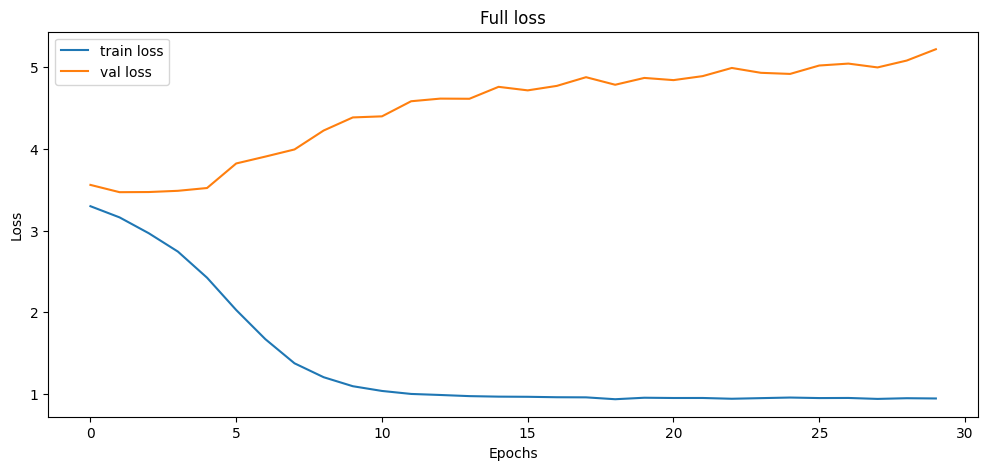

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(crnn_model_1.history["loss"], label="train loss")
plt.plot(crnn_model_1.history["val_loss"], label="val loss")
plt.legend()
plt.title("Full loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


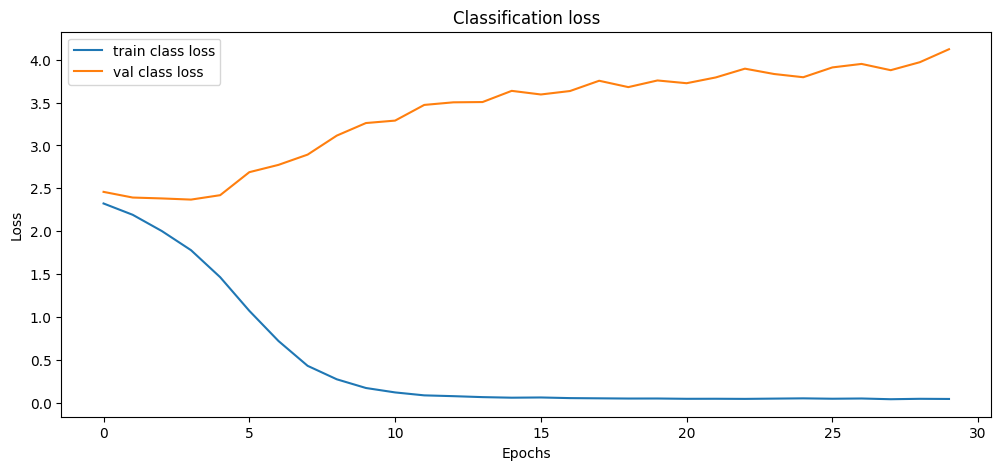

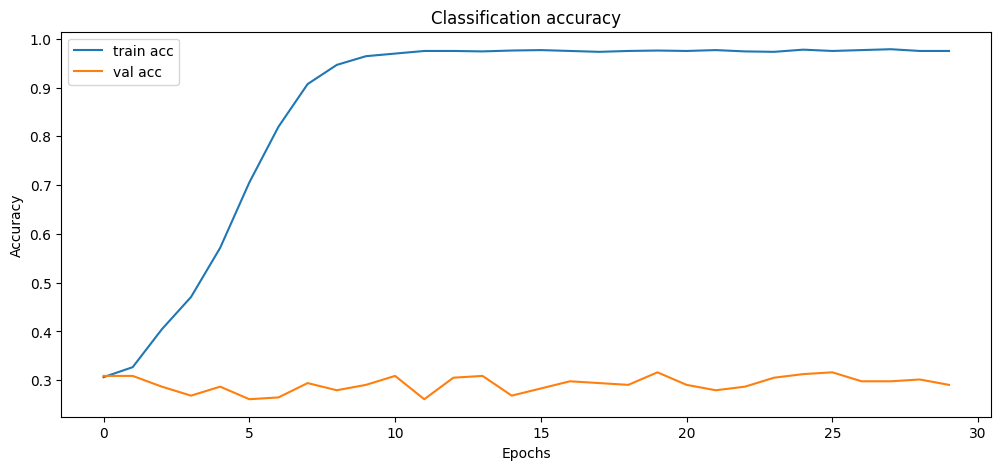

In [32]:
plt.figure(figsize=(12,5))
plt.plot(crnn_model_1.history["class_output_loss"], label="train class loss")
plt.plot(crnn_model_1.history["val_class_output_loss"], label="val class loss")
plt.legend()
plt.title("Classification loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(crnn_model_1.history["class_output_accuracy"], label="train acc")
plt.plot(crnn_model_1.history["val_class_output_accuracy"], label="val acc")
plt.legend()
plt.title("Classification accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()


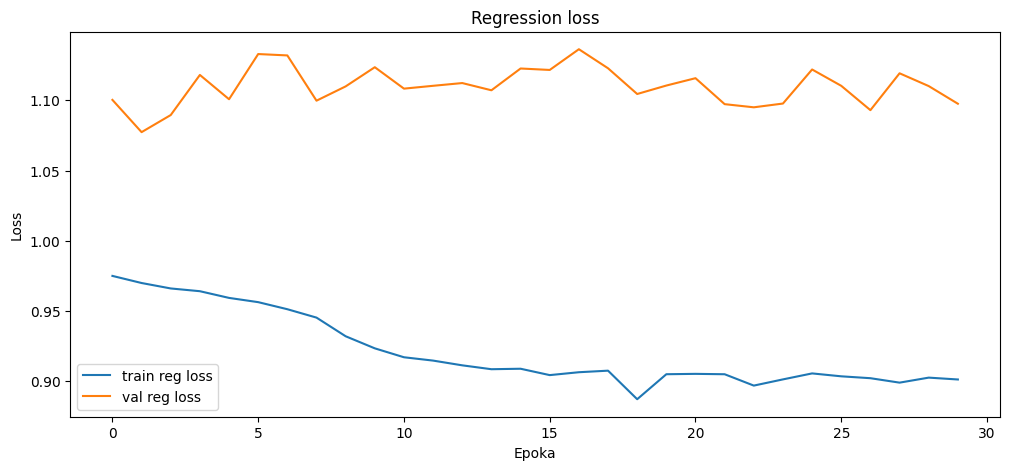

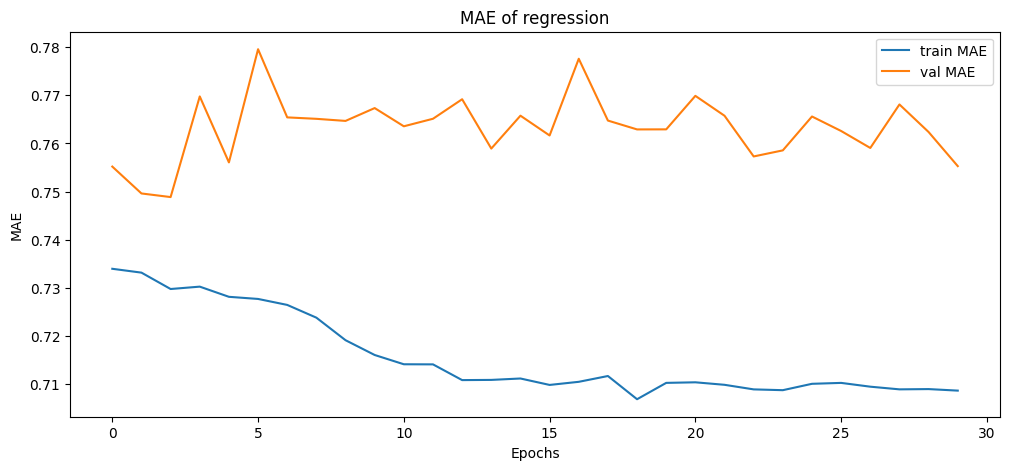

In [33]:
plt.figure(figsize=(12,5))
plt.plot(crnn_model_1.history["reg_output_loss"], label="train reg loss")
plt.plot(crnn_model_1.history["val_reg_output_loss"], label="val reg loss")
plt.legend()
plt.title("Regression loss")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(crnn_model_1.history["reg_output_mae"], label="train MAE")
plt.plot(crnn_model_1.history["val_reg_output_mae"], label="val MAE")
plt.legend()
plt.title("MAE of regression")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.show()


In [34]:
crnn_model.save("crnn_model.h5")